## Pixel Shuffle Super Resolution

this notebook is created by the help of  Devjyoti Chakraborty's blog about superresolution with pixel shift (https://pyimagesearch.com/2021/09/27/pixel-shuffle-super-resolution-with-tensorflow-keras-and-deep-learning/?_ga=2.36718432.1725668903.1675464178-1130789896.1638882117) . Most of the code blocks and images are taken from that blog. 

For clarification, I added some codes and explanations what we do.

Pixel Shuffle Super Resolution is an upsampling technique where Image Super Resolution is achieved in a rather ingenious method. Feature maps are extracted in its LR (Low-Resolution) space (as opposed to earlier techniques where this was done in the HR (High-Resolution) space).
However, the highlight of this method is a novel efficient sub-pixel convolution layer, which learns an array of filters to upscale the final LR feature maps into the HR output. Not only does this method achieve great success, but it also reduces time complexity, since a chunk of the computation is done while the image is in its low-resolution state.


we will use the BSDS500, also known as the Berkeley Segmentation Dataset


In [1]:
# first we need to define some parameters about paths, dimension and outputs
import os

#BSDS500 dataset
ROOT_PATH = os.path.join("BSR", "BSDS500", "data", "images")

# specify paths to the different splits of the dataset
TRAIN_SET = os.path.join(ROOT_PATH, "train")
VAL_SET = os.path.join(ROOT_PATH, "val")
TEST_SET = os.path.join(ROOT_PATH, "test")

# specify the initial size of the images and downsampling factor
ORIG_SIZE = (300, 300)
DOWN_FACTOR = 3

# specify number of layers in a RDB block, batch size, number of
# epochs, and initial learning rate to train our model
RDB_LAYERS = 3
BATCH_SIZE = 8
EPOCHS = 100
LR = 1e-3

# define paths to serialize trained model, training history plot, and
# path to our inference visualizations
SUPER_RES_MODEL = os.path.join("output", "super_res_model")
TRAINING_PLOT = os.path.join("output", "training.png")
VISUALIZATION_PATH = os.path.join("output", "visualizations")

At the image preprocess stage, we will resize images and take their specific channels. For clearification , first I will show each steps and outputs, then collect them in a function for all images.

In [3]:
import tensorflow as tf
imagePath='pix_shift_example.jpg'

resizeShape = ORIG_SIZE[0] // DOWN_FACTOR
print('resize shape will be {}'.format(resizeShape))

resize shape will be 100


In [4]:
origImage = tf.io.read_file(imagePath)
origImage = tf.image.decode_jpeg(origImage, 3)


In [5]:
origImage

<tf.Tensor: shape=(321, 481, 3), dtype=uint8, numpy=
array([[[ 46,  63,  55],
        [ 25,  40,  33],
        [ 25,  38,  31],
        ...,
        [ 59, 105,  58],
        [ 64, 110,  63],
        [ 59, 106,  62]],

       [[ 46,  63,  55],
        [ 21,  36,  29],
        [ 23,  36,  29],
        ...,
        [ 50,  96,  47],
        [ 48,  94,  47],
        [ 49,  96,  50]],

       [[ 46,  61,  54],
        [ 18,  33,  26],
        [ 20,  33,  26],
        ...,
        [ 49,  95,  46],
        [ 34,  80,  33],
        [ 41,  87,  41]],

       ...,

       [[ 66,  71,  39],
        [ 65,  70,  38],
        [ 67,  72,  40],
        ...,
        [ 81,  88,  57],
        [ 70,  77,  46],
        [ 77,  84,  51]],

       [[ 88,  92,  59],
        [ 90,  94,  61],
        [ 89,  93,  60],
        ...,
        [ 81,  87,  53],
        [ 66,  72,  38],
        [ 65,  71,  37]],

       [[ 83,  84,  50],
        [ 92,  93,  59],
        [ 93,  93,  59],
        ...,
        [ 84,  90,  5

In [6]:
#scale its pixel values to [0, 1] range
origImage= tf.image.convert_image_dtype(origImage, tf.float32)

In [7]:
origImage

<tf.Tensor: shape=(321, 481, 3), dtype=float32, numpy=
array([[[0.18039216, 0.24705884, 0.21568629],
        [0.09803922, 0.15686275, 0.12941177],
        [0.09803922, 0.14901961, 0.12156864],
        ...,
        [0.23137257, 0.41176474, 0.227451  ],
        [0.2509804 , 0.43137258, 0.24705884],
        [0.23137257, 0.4156863 , 0.24313727]],

       [[0.18039216, 0.24705884, 0.21568629],
        [0.08235294, 0.14117648, 0.1137255 ],
        [0.09019608, 0.14117648, 0.1137255 ],
        ...,
        [0.19607845, 0.37647063, 0.18431373],
        [0.18823531, 0.36862746, 0.18431373],
        [0.19215688, 0.37647063, 0.19607845]],

       [[0.18039216, 0.2392157 , 0.21176472],
        [0.07058824, 0.12941177, 0.10196079],
        [0.07843138, 0.12941177, 0.10196079],
        ...,
        [0.19215688, 0.37254903, 0.18039216],
        [0.13333334, 0.3137255 , 0.12941177],
        [0.16078432, 0.34117648, 0.16078432]],

       ...,

       [[0.25882354, 0.2784314 , 0.15294118],
        [0.25

In [8]:
#resize it to original scale which is 300,300 for our case
origImage = tf.image.resize(origImage,ORIG_SIZE,method="area")

In [9]:
origImage

<tf.Tensor: shape=(300, 300, 3), dtype=float32, numpy=
array([[[0.14901665, 0.21273193, 0.18283509],
        [0.09642128, 0.14732014, 0.12088013],
        [0.08464406, 0.11399469, 0.09636801],
        ...,
        [0.2696735 , 0.4615356 , 0.25580066],
        [0.23730615, 0.41965398, 0.23202053],
        [0.23560609, 0.41844407, 0.24114802]],

       [[0.14292082, 0.20599608, 0.17641924],
        [0.08627702, 0.13730817, 0.11080201],
        [0.09050673, 0.12114276, 0.10300299],
        ...,
        [0.24894172, 0.43691772, 0.23299627],
        [0.19959928, 0.3810023 , 0.1892695 ],
        [0.1854178 , 0.3679357 , 0.18606795]],

       [[0.13581195, 0.19309619, 0.16564521],
        [0.07639176, 0.12792076, 0.10097525],
        [0.09152186, 0.13147444, 0.10953738],
        ...,
        [0.20770027, 0.3939543 , 0.19003282],
        [0.18788941, 0.36977246, 0.17621876],
        [0.15018083, 0.33153293, 0.1481259 ]],

       ...,

       [[0.26226494, 0.28341216, 0.15869072],
        [0.27

In [10]:
# convert the color space from RGB to YUV and only keep the Y channel
origImageYUV = tf.image.rgb_to_yuv(origImage)
(target, _, _) = tf.split(origImageYUV, 3, axis=-1)

In [11]:
target

<tf.Tensor: shape=(300, 300, 1), dtype=float32, numpy=
array([[[0.19027281],
        [0.12908722],
        [0.10320941],
        ...,
        [0.38071504],
        [0.34374177],
        [0.34356377]],

       [[0.18376483],
        [0.11902816],
        [0.10991465],
        ...,
        [0.35746586],
        [0.30490527],
        [0.29262993]],

       [[0.17283879],
        [0.1094418 ],
        [0.1170278 ],
        ...,
        [0.3150173 ],
        [0.29332432],
        [0.25640026]],

       ...,

       [[0.2628709 ],
        [0.2756108 ],
        [0.28917292],
        ...,
        [0.3177753 ],
        [0.2999285 ],
        [0.2909121 ]],

       [[0.33284685],
        [0.3337971 ],
        [0.32026845],
        ...,
        [0.32779285],
        [0.30882388],
        [0.26274762]],

       [[0.32749793],
        [0.3454681 ],
        [0.31941077],
        ...,
        [0.34814247],
        [0.32842064],
        [0.3122871 ]]], dtype=float32)>

In [12]:
# resize the target to a lower resolution(100,100)
downImage = tf.image.resize(target, [resizeShape, resizeShape],method="area")

In [13]:
downImage

<tf.Tensor: shape=(100, 100, 1), dtype=float32, numpy=
array([[[0.13717617],
        [0.11090532],
        [0.16859682],
        ...,
        [0.2748809 ],
        [0.29028207],
        [0.32086262]],

       [[0.12198348],
        [0.11085141],
        [0.13326792],
        ...,
        [0.2842248 ],
        [0.30442294],
        [0.3302664 ]],

       [[0.12272885],
        [0.12346457],
        [0.13380308],
        ...,
        [0.31817356],
        [0.33005276],
        [0.36210817]],

       ...,

       [[0.2671123 ],
        [0.28151736],
        [0.2729321 ],
        ...,
        [0.15092246],
        [0.14516012],
        [0.15654455]],

       [[0.26827762],
        [0.267557  ],
        [0.29339293],
        ...,
        [0.26956606],
        [0.25433296],
        [0.21260677]],

       [[0.31188264],
        [0.31579176],
        [0.31561634],
        ...,
        [0.30947194],
        [0.3079152 ],
        [0.31075898]]], dtype=float32)>

In [14]:

target = tf.clip_by_value(target, 0.0, 1.0)
downImage = tf.clip_by_value(downImage, 0.0, 1.0)

In [15]:
target

<tf.Tensor: shape=(300, 300, 1), dtype=float32, numpy=
array([[[0.19027281],
        [0.12908722],
        [0.10320941],
        ...,
        [0.38071504],
        [0.34374177],
        [0.34356377]],

       [[0.18376483],
        [0.11902816],
        [0.10991465],
        ...,
        [0.35746586],
        [0.30490527],
        [0.29262993]],

       [[0.17283879],
        [0.1094418 ],
        [0.1170278 ],
        ...,
        [0.3150173 ],
        [0.29332432],
        [0.25640026]],

       ...,

       [[0.2628709 ],
        [0.2756108 ],
        [0.28917292],
        ...,
        [0.3177753 ],
        [0.2999285 ],
        [0.2909121 ]],

       [[0.33284685],
        [0.3337971 ],
        [0.32026845],
        ...,
        [0.32779285],
        [0.30882388],
        [0.26274762]],

       [[0.32749793],
        [0.3454681 ],
        [0.31941077],
        ...,
        [0.34814247],
        [0.32842064],
        [0.3122871 ]]], dtype=float32)>

The target and downImage will be our dataset for model. Now build a function for these steps

In [16]:
def process_input(imagePath, downFactor=DOWN_FACTOR):
    # determine size of the downsampled images
    resizeShape = ORIG_SIZE[0] // downFactor

    # load the original image from disk, decode it as a JPEG image,
    # scale its pixel values to [0, 1] range, and resize the image
    origImage = tf.io.read_file(imagePath)
    origImage = tf.image.decode_jpeg(origImage, 3)
    origImage = tf.image.convert_image_dtype(origImage, tf.float32)
    origImage = tf.image.resize(origImage, ORIG_SIZE,
        method="area")

    # convert the color space from RGB to YUV and only keep the Y
    # channel (which is our target variable)
    origImageYUV = tf.image.rgb_to_yuv(origImage)
    (target, _, _) = tf.split(origImageYUV, 3, axis=-1)

    # resize the target to a lower resolution
    downImage = tf.image.resize(target, [resizeShape, resizeShape],
        method="area")

    # clip the values of the input and target to [0, 1] range
    target = tf.clip_by_value(target, 0.0, 1.0)
    downImage = tf.clip_by_value(downImage, 0.0, 1.0)

    # return a tuple of the downsampled image and original image
    return (downImage, target)

When we had first learned about CNNs, a predominant theme about them was that the layers of a CNN extract simple features to increasingly complex/abstract/high-level features as we traverse from the initial layers to the later ones.

RDBs intend to exploit this idea as much as they can, by extracting as many hierarchical features as possible with a densely connected network of convolution layers. 

all layers are interconnected to ensure abundant extraction of local features. Each layer obtains additional inputs from all the previous layers (through concatenation) and passes on its own feature maps to subsequent layers.

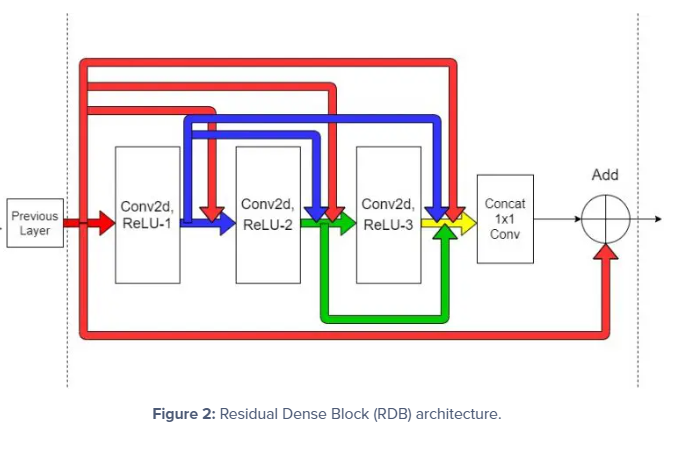

This way, the feedforward nature of the network is also preserved. Notice another important thing; the output from the previous layers has a direct link to all local connections within the present RDB. The simplest implication of this is that the information from a previous layer will always be available along with the present states, which enables our model to choose and prioritize from a variety of features adaptively. Thus, every bit of information is saved!

By its formal definition, it is a function that rearranges data from depth into blocks of spatial data. Understanding this is our key to debunking the mystery of Pixel Shuffle.

When we are talking about depth, we are referring to the number of channels in our tensor (speaking in image terms). So, if we have a tensor of shape 2, 2, 12 and we want to apply depth_to_space on it with a factor (also known as block_size) of 2, we have to see how the channel size is getting divided by block_size × block_size. So for channel size 12, we see that 12/(2×2) gives us the new channel size 3.

But since our channel size is reduced to 3, we obviously have to increase our height and width to maintain the overall size of the tensor as we are not losing data, just rearranging it. This gives us the final tensor shape of 4, 4, 3.

This phenomenon is what we term as pixel shuffle, where we are rearranging the elements of H \times W \times ( C * r * r) to (H*r) \times (W*r) \times C.

Note, even if this is our final output, tf.nn.depth_to_space is NOT a learnable parameter of the model. This means that the Conv2D layer right before it has to learn its upscaling filters properly so that the final output produces minimal loss during backpropagation.

Lets begin to build our model architecture...

In [2]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [18]:
def rdb_block(inputs, numLayers):
    # determine the number of channels present in the current input
    # and initialize a list with the current inputs for concatenation
    channels = inputs.get_shape()[-1]
    storedOutputs = [inputs]

    # iterate through the number of residual dense layers
    for _ in range(numLayers):
        # concatenate the previous outputs and pass it through a
        # CONV layer, and append the output to the ongoing concatenation
        localConcat = tf.concat(storedOutputs, axis=-1)
        out = Conv2D(filters=channels, kernel_size=3, padding="same",
                     activation="relu",
                     kernel_initializer="Orthogonal")(localConcat)
        storedOutputs.append(out)

    # concatenate all the outputs, pass it through a pointwise
    # convolutional layer, and add the outputs to initial inputs
    finalConcat = tf.concat(storedOutputs, axis=-1)
    finalOut = Conv2D(filters=inputs.get_shape()[-1], kernel_size=1,
                      padding="same",
                      activation="relu",
                      kernel_initializer="Orthogonal")(finalConcat)
    finalOut = Add()([finalOut, inputs])

    # return the final output
    return finalOut

In [19]:
def get_subpixel_net(downsampleFactor=DOWN_FACTOR, channels=1,
                     rdbLayers=RDB_LAYERS):
    # initialize an input layer
    inputs = Input((None, None, 1))

    # pass the inputs through a CONV => CONV block
    x = Conv2D(64, 5, padding="same", activation="relu",
               kernel_initializer="Orthogonal")(inputs)
    x = Conv2D(64, 3, padding="same", activation="relu",
               kernel_initializer="Orthogonal")(x)

    # pass the outputs through an RDB => CONV => RDB block
    x = rdb_block(x, numLayers=rdbLayers)
    x = Conv2D(32, 3, padding="same", activation="relu",
               kernel_initializer="Orthogonal")(x)
    x = rdb_block(x, numLayers=rdbLayers)

    # pass the inputs through a final CONV layer such that the
    # channels of the outputs can be spatially organized into
    # the output resolution
    x = Conv2D(channels * (downsampleFactor ** 2), 3, padding="same",
               activation="relu", kernel_initializer="Orthogonal")(x)
    outputs = tf.nn.depth_to_space(x, downsampleFactor)

    # construct the final model and return it
    model = Model(inputs, outputs)
    return model

In [3]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

 we define a function called psnr, which takes an original image and a predicted image as its arguments. Our main intention is to calculate the Peak Signal to Noise Ratio (PSNR) by comparing the original and predicted images.

In [21]:
def psnr(orig, pred):
    # cast the target images to integer
    orig = orig * 255.0
    orig = tf.cast(orig, tf.uint8)
    orig = tf.clip_by_value(orig, 0, 255)

    # cast the predicted images to integer
    pred = pred * 255.0
    pred = tf.cast(pred, tf.uint8)
    pred = tf.clip_by_value(pred, 0, 255)

    # return the psnr
    return tf.image.psnr(orig, pred, max_val=255)

 we are upscaling the pixel values from the range [0.0, 1.0] to [0, 255]. The tensors are also getting cast into integers for easier calculations. For the PSNR calculations, we use the tf.image.psnr function (Line 24). As the name suggests, the higher the value of the ratio, the lower the value of the noise. The psnr function will also act as our model metric.

In [24]:
model = get_subpixel_net()

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1664        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                           

In [4]:
from tensorflow.keras.utils import plot_model
from PIL import Image

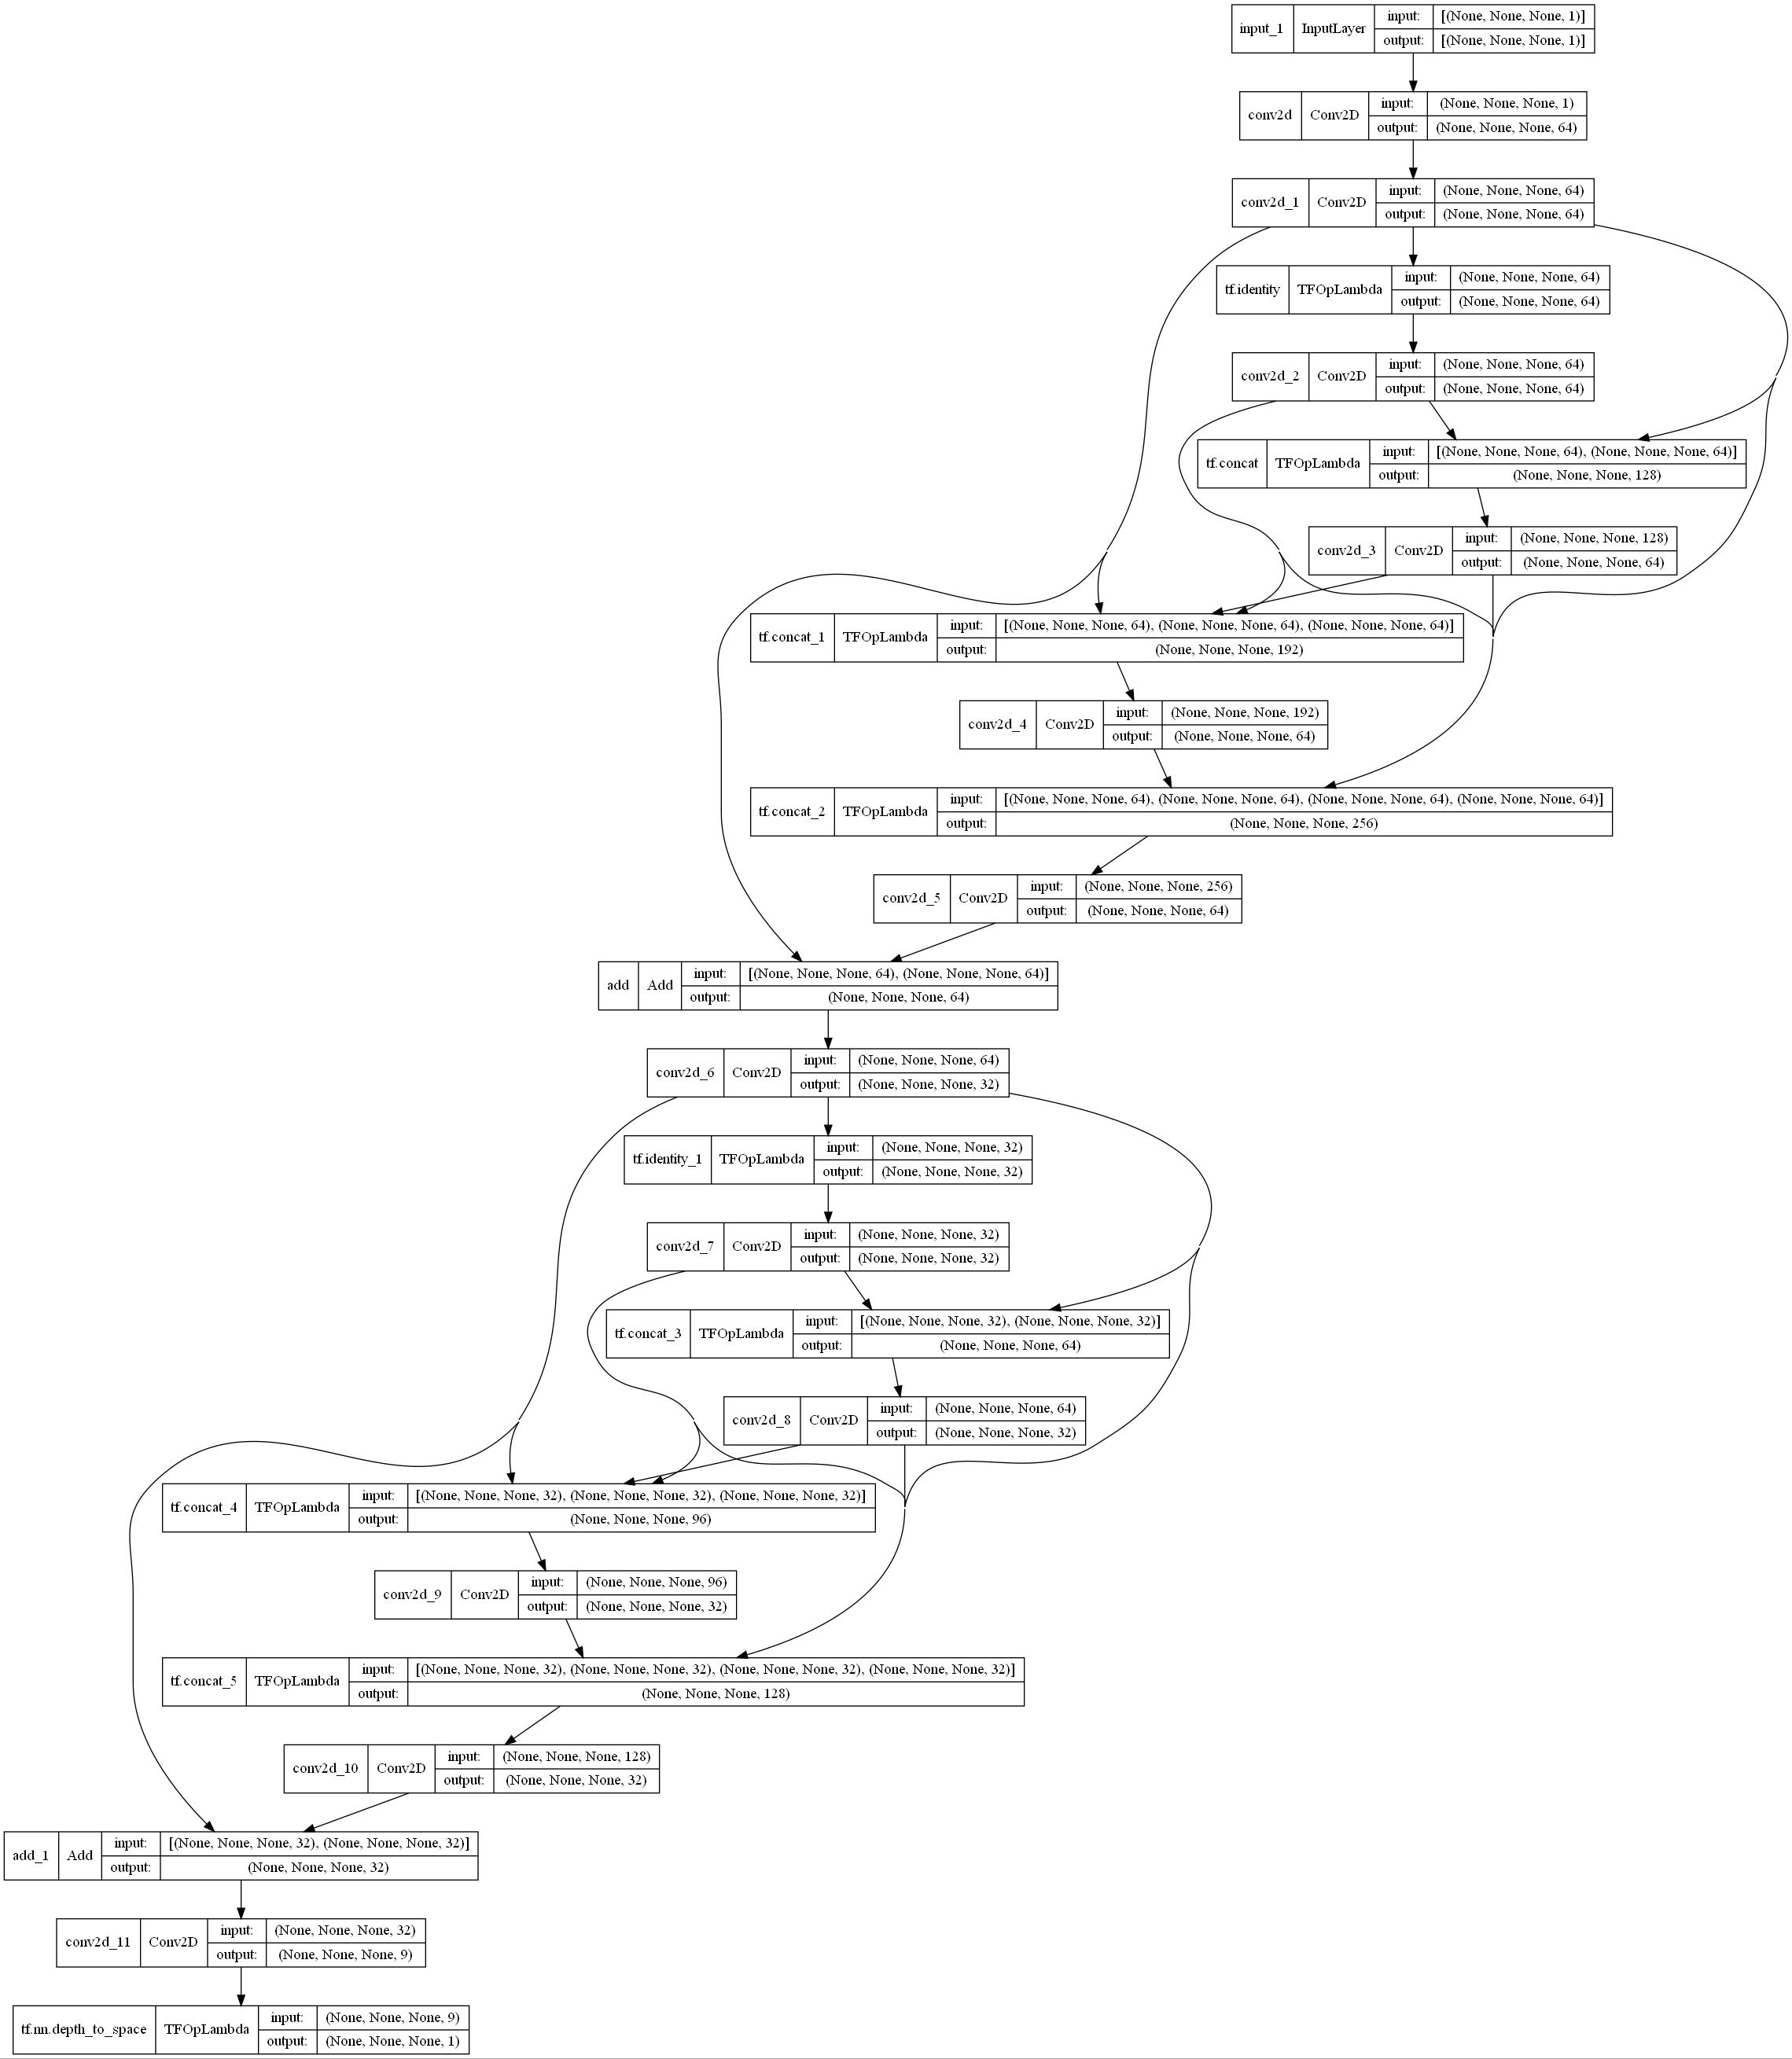

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='my_pixel_shift.jpg')

our model is ready, we also define a specific lost function. Now it is time to create our datasets and train our model

In [28]:
# define autotune flag for performance optimization
AUTO = tf.data.AUTOTUNE

# load the image paths from disk and initialize TensorFlow Dataset
# objects
print("[INFO] loading images from disk...")
trainPaths = list(paths.list_images(TRAIN_SET))
valPaths = list(paths.list_images(VAL_SET))
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
valDS = tf.data.Dataset.from_tensor_slices(valPaths)

# prepare data loaders
print("[INFO] preparing data loaders...")
trainDS = trainDS.map(process_input,
                      num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
valDS = valDS.map(process_input,
                  num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)


[INFO] loading images from disk...
[INFO] preparing data loaders...


In [29]:
model.compile(optimizer="adam", loss="mse", metrics=psnr)
H = model.fit(trainDS, validation_data=valDS, epochs=EPOCHS)

Epoch 1/100
25/25 [==============================] - 13s 116ms/step - loss: 0.0919 - psnr: 11.0817 - val_loss: 0.0141 - val_psnr: 17.0962
Epoch 2/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0094 - psnr: 19.8332 - val_loss: 0.0068 - val_psnr: 21.4137
Epoch 3/100
25/25 [==============================] - 2s 65ms/step - loss: 0.0054 - psnr: 22.3499 - val_loss: 0.0045 - val_psnr: 21.5812
Epoch 4/100
25/25 [==============================] - 2s 65ms/step - loss: 0.0039 - psnr: 23.5338 - val_loss: 0.0035 - val_psnr: 24.0932
Epoch 5/100
25/25 [==============================] - 2s 64ms/step - loss: 0.0032 - psnr: 24.4514 - val_loss: 0.0030 - val_psnr: 24.2585
Epoch 6/100
25/25 [==============================] - 2s 65ms/step - loss: 0.0029 - psnr: 24.5902 - val_loss: 0.0029 - val_psnr: 24.9678
Epoch 7/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0027 - psnr: 24.8597 - val_loss: 0.0026 - val_psnr: 25.0408
Epoch 8/100
25/25 [===========================

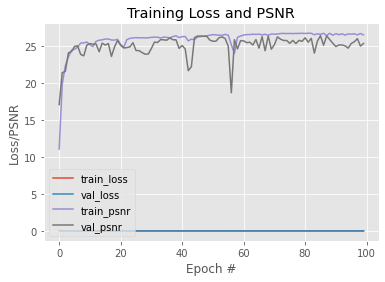

In [30]:
# prepare training plot of the model and serialize it
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["psnr"], label="train_psnr")
plt.plot(H.history["val_psnr"], label="val_psnr")
plt.title("Training Loss and PSNR")
plt.xlabel("Epoch #")
plt.ylabel("Loss/PSNR")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT)


In [31]:

# serialize the trained model
print("[INFO] serializing model...")
model.save(SUPER_RES_MODEL)

[INFO] serializing model...
INFO:tensorflow:Assets written to: output\super_res_model\assets


C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


We trained our model and save it in output folder. Now we use this model to generate superresolution image

again first I will explain step by step , then make it a function to use on 10 images

In [5]:
def psnr(orig, pred):
    # cast the target images to integer
    orig = orig * 255.0
    orig = tf.cast(orig, tf.uint8)
    orig = tf.clip_by_value(orig, 0, 255)

    # cast the predicted images to integer
    pred = pred * 255.0
    pred = tf.cast(pred, tf.uint8)
    pred = tf.clip_by_value(pred, 0, 255)

    # return the psnr
    return tf.image.psnr(orig, pred, max_val=255)

In [44]:
# load our super-resolution model from disk
print("[INFO] loading model...")
superResModel = load_model(SUPER_RES_MODEL,custom_objects={"psnr" : psnr})

[INFO] loading model...


In [ ]:
C:\Users\Zeki\Desktop\kisisel calismalar\github_notebooks\superresolution\pyimage_origin\super-resolution-pixel-shuffle\output\super_res_model\saved_model.pb

In [8]:
imagePath='pix_shift_example.jpg'
orig = load_img(imagePath)
downsampled = orig.resize((orig.size[0] // DOWN_FACTOR,orig.size[1] // DOWN_FACTOR), Image.BICUBIC)


C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\648530106.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  downsampled = orig.resize((orig.size[0] // DOWN_FACTOR,orig.size[1] // DOWN_FACTOR), Image.BICUBIC)


In [11]:
# we need to take the Y channel of image
ycbcr = downsampled.convert("YCbCr")
(y, cb, cr) = ycbcr.split()

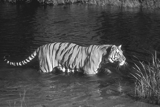

In [13]:
y

In [14]:
# convert the y-channel to a numpy array, cast it to float, and
# scale its pixel range to [0, 1]
y = np.array(y)
y = y.astype("float32") / 255.0

In [15]:
upscaledY = superResModel.predict(y[None, ...])[0]

In [17]:
upscaledY.shape

(321, 480, 1)

our model's output is an array of Y channel. Because of that, we need a postprocess to show image.

In [19]:
def clip_numpy(image):
    # cast image to integer, clip its pixel range to [0, 255]
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.clip_by_value(image, 0, 255).numpy()

    # return the image
    return image

In [20]:
y = clip_numpy(upscaledY).squeeze()
y = y.reshape(y.shape[0], y.shape[1])
y = Image.fromarray(y, mode="L")

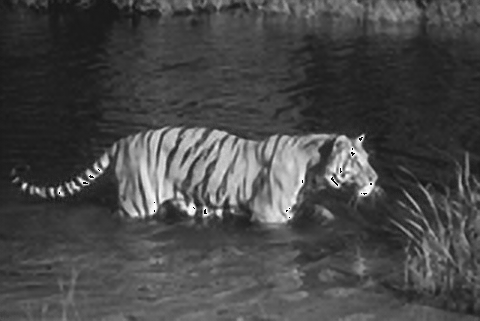

In [21]:
y

In [22]:
# resize the other channels of the image to match the original
# dimension
outputCB = cb.resize(y.size, Image.BICUBIC)
outputCR = cr.resize(y.size, Image.BICUBIC)

C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\1567526927.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  outputCB = cb.resize(y.size, Image.BICUBIC)
C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\1567526927.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  outputCR = cr.resize(y.size, Image.BICUBIC)


In [23]:
final = Image.merge("YCbCr", (y, outputCB, outputCR)).convert("RGB")

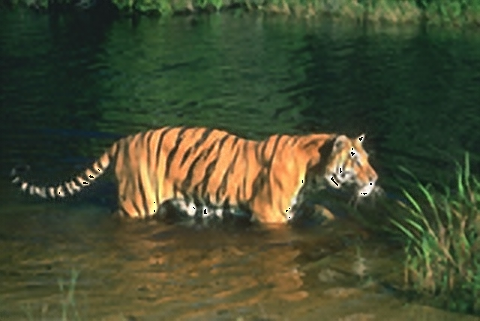

In [24]:
final

In [25]:
finalOutput=np.array(final)

In [27]:
finalOutput.shape

(321, 480, 3)

In [28]:
naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)

C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\3909830529.py:1: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)


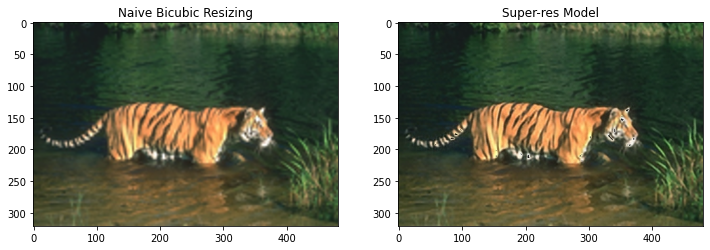

In [31]:
# visualize the results and save them to disk
path = os.path.join(VISUALIZATION_PATH, "example_viz.png")
(fig, (ax1, ax2)) = plt.subplots(ncols=2, figsize=(12, 12))
ax1.imshow(naiveResizing)
ax2.imshow(finalOutput.astype("int"))
ax1.set_title("Naive Bicubic Resizing")
ax2.set_title("Super-res Model")
fig.savefig(path, dpi=300, bbox_inches="tight")

we will apply this process for ten images 

In [39]:
def load_image(imagePath):
    # load image from disk and downsample it using the bicubic method
    orig = load_img(imagePath)
    downsampled = orig.resize((orig.size[0] // DOWN_FACTOR,
        orig.size[1] // DOWN_FACTOR), Image.BICUBIC)

    # return a tuple of the original and downsampled image
    return (orig, downsampled)

def get_y_channel(image):
    # convert the image to YCbCr colorspace and then split it get the
    # individual channels
    ycbcr = image.convert("YCbCr")
    (y, cb, cr) = ycbcr.split()

    # convert the y-channel to a numpy array, cast it to float, and
    # scale its pixel range to [0, 1]
    y = np.array(y)
    y = y.astype("float32") / 255.0

    # return a tuple of the individual channels
    return (y, cb, cr)

In [33]:
def postprocess_image(y, cb, cr):
    # do a bit of initial preprocessing, reshape it to match original
    # size, and then convert it to a PIL Image
    y = clip_numpy(y).squeeze()
    y = y.reshape(y.shape[0], y.shape[1])
    y = Image.fromarray(y, mode="L")

    # resize the other channels of the image to match the original
    # dimension
    outputCB = cb.resize(y.size, Image.BICUBIC)
    outputCR = cr.resize(y.size, Image.BICUBIC)

    # merge the resized channels altogether and return it as a numpy
    # array
    final = Image.merge("YCbCr", (y, outputCB, outputCR)).convert("RGB")
    return np.array(final)

In [35]:
print("[INFO] loading test images...")
testPaths = list(paths.list_images(TEST_SET))
currentTestPaths = np.random.choice(testPaths, 10)

[INFO] loading test images...


[INFO] performing predictions...


C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\3530317418.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  orig.size[1] // DOWN_FACTOR), Image.BICUBIC)
C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\265333710.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  outputCB = cb.resize(y.size, Image.BICUBIC)
C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\265333710.py:11: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  outputCR = cr.resize(y.size, Image.BICUBIC)
C:\Users\Zeki\AppData\Local\Temp\ipykernel_22016\2030277279.py:15: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)


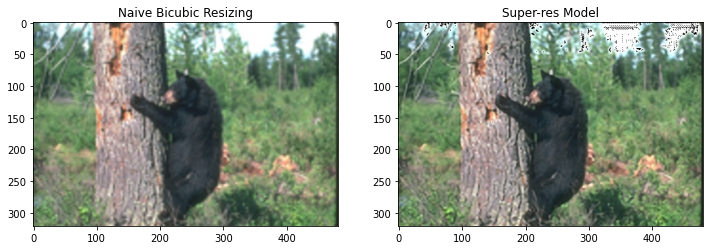

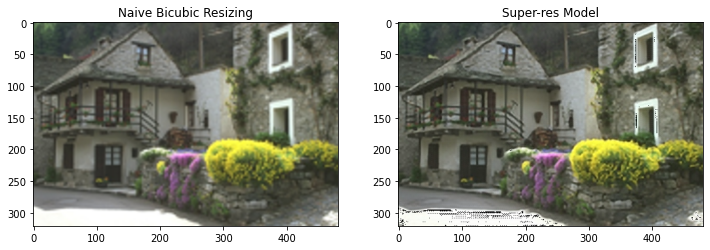

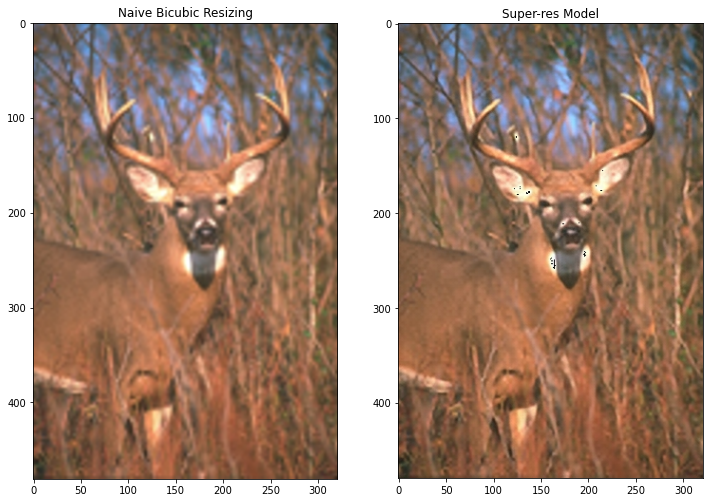

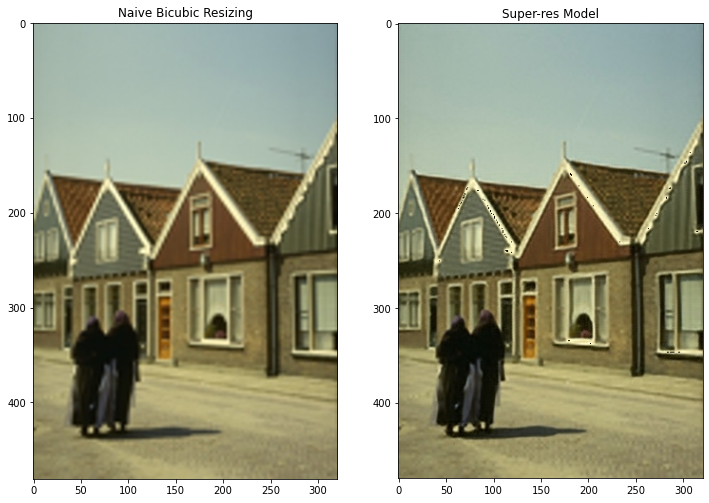

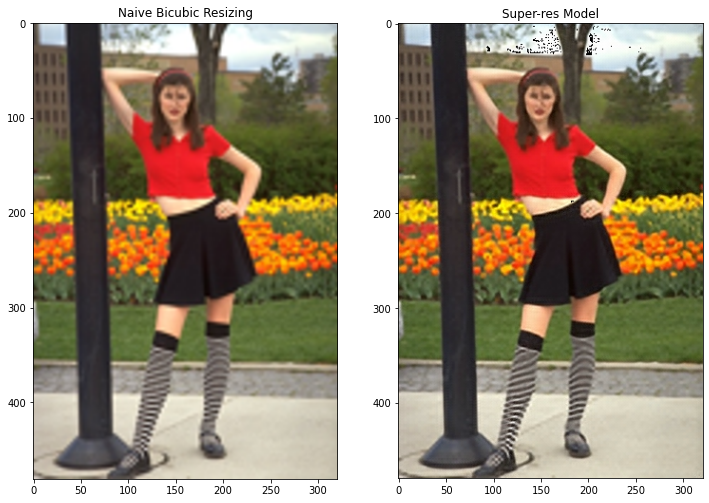

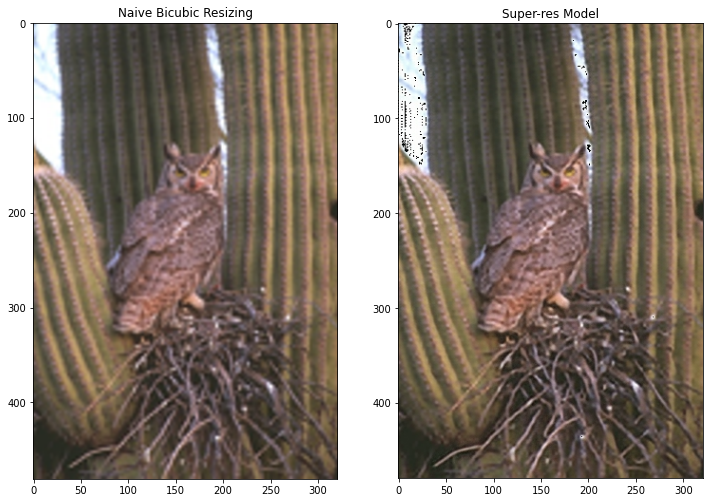

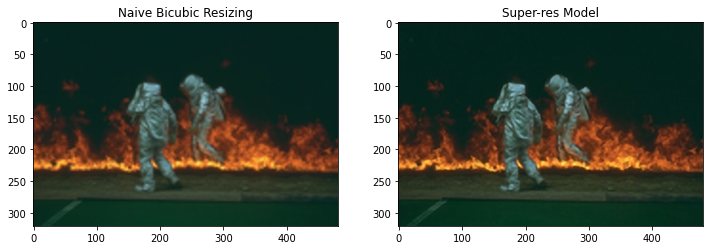

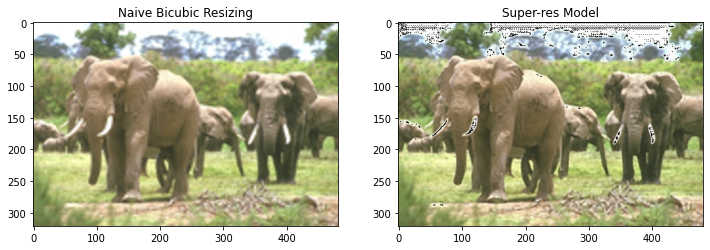

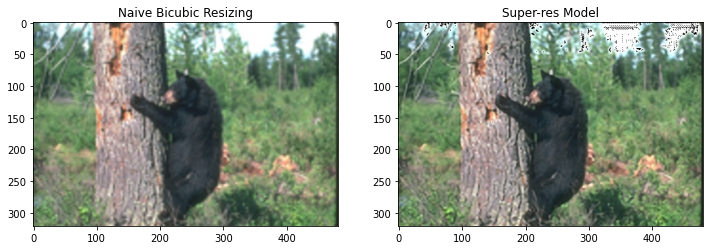

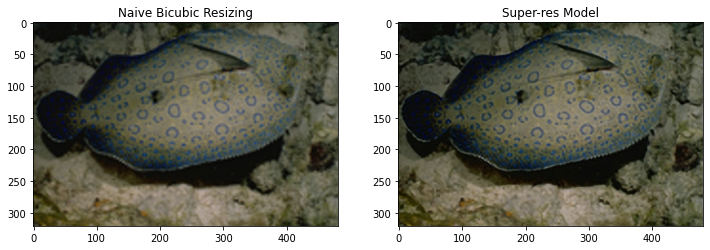

In [43]:
print("[INFO] performing predictions...")
for (i, path) in enumerate(currentTestPaths):
    # grab the original and the downsampled images from the
    # current path
    (orig, downsampled) = load_image(path)

    # retrieve the individual channels of the current image and perform
    # inference
    (y, cb, cr) = get_y_channel(downsampled)
    upscaledY = superResModel.predict(y[None, ...])[0]

    # postprocess the output and apply the naive bicubic resizing to
    # the downsampled image for comparison
    finalOutput = postprocess_image(upscaledY, cb, cr)
    naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)

    # visualize the results and save them to disk
    path = os.path.join(VISUALIZATION_PATH, f"{i}_viz.png")
    (fig, (ax1, ax2)) = plt.subplots(ncols=2, figsize=(12, 12))
    ax1.imshow(naiveResizing)
    ax2.imshow(finalOutput.astype("int"))
    ax1.set_title("Naive Bicubic Resizing")
    ax2.set_title("Super-res Model")
    fig.savefig(path, dpi=300, bbox_inches="tight")

 The images from super-res are sharper than naice bibubic images. But there are some mistakes about white pixels... We should play with our models parameter for better results. On the otherhand, we trained a model for superresolution with pixel shift and applied this process on images
 
 If you follow my github, in the next notebook we trained with 12 epoch and the book says : 'You might have noticed that we didn't train for many epochs (only 12). This is by design because it's been shown that training for too long can actually hurt the network's performance.'.. This is the case here for us